# Telemetry data fetching & processing

## Data Ingestion

In [1]:
#Load API credentials from .env file & initialize global variables 

import os
from dotenv import load_dotenv

# Load secret .env file
load_dotenv()

# Store credentials
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.getenv('CLIENT_SECRET')

# Verify it worked
#if CLIENT_ID is not None and CLIENT_SECRET is not None:
    #print(CLIENT_ID)
    #print(CLIENT_SECRET)

#other global variables
THING_ID = "7db1852a-9709-471f-b049-7505253ceaad" #id of Arduino Thing of interest (telemetry)
SPACE_ID = '6b795d20-54e3-483c-a322-7114527741a1' #id of the shared space needed to access data

### Get data from Arduino IOT


In [2]:
import requests
import pandas as pd
import json
import time

#returns standard header to be included when making http request to API
#stardard header includes the authorization (access token) and x-organization (space id)
#to be used before each API call (tokens expire every 3 minutes i believe)
def getHeader():
      client = requests.request('POST', 'https://api2.arduino.cc/iot/v1/clients/token',
                        headers={'content-type': 'application/x-www-form-urlencoded'},
                        data={'grant_type':'client_credentials',
                              'client_id':CLIENT_ID,
                              'client_secret':CLIENT_SECRET,
                              'audience':'https://api2.arduino.cc/iot'})

      access_token = 'Bearer '+ client.json()['access_token']

      #standard header for the http requests
      header = {'authorization':access_token,'x-organization':SPACE_ID}
      
      return header



### Merge returned data into dataframe

In [3]:

import concurrent.futures


class Property():
    """
    represents a property of an arduino "Thing"

    holds instance and class functions for making 
    property data requests from Arduino Cloud 
    """
    
    def __init__(self, name, id, thing_id):
        self.name = name
        self.id = id
        self.thing_id = thing_id

    #get the data for one specific property
    #interval: data binning interval in seconds, smallest possible interval is 1s

    def fetch_timeseries(self, header, from_t, interval=1):
        """"
        fetches the timeseries data of the Property by calling the Arduino API propertiesV2Timeseries method:
        https://www.arduino.cc/reference/en/iot/api/#api-PropertiesV2-propertiesV2Timeseries

        note: limit of 1000 data point returns

        params:
            header: http request header
            from_t: the start time of the timeseries
            interval: data binning interval in seconds, smallest possible interval is 1s

        returns unprocessed data (in json format)
        """
        url = f"https://api2.arduino.cc/iot/v2/things/{self.thing_id}/properties/{self.id}/timeseries?desc=true&from={from_t}&interval={interval}"
        req = requests.request('GET', url, headers=header)
        return req.json()['responses']

    def render_raw_data_query_dict(self, from_t, to_t, sort='DESC') -> dict:
        """
        helper function for raw data queries 
        returns dictionary of query request parameters
        """
        #dictionary with request parameters
        req = {"q": f"property.{self.id}", "sort" : sort}
        if from_t: req["from"] = from_t
        if to_t: req["to"] = to_t

        return req

    def fetch_raw_data(self, header, from_t, to_t=None, sort='DESC'):
        """
        calls the Arduino API seriesV2BatchQueryRaw method for the Property instance:
        https://www.arduino.cc/reference/en/iot/api/#api-SeriesV2-seriesV2BatchQueryRaw

        params:
            header: http request header
            from_t: the start of the desired time range
            to_t: the end of the desired time range
           
        note: a limit of 1000 data points can be returned. 
        it will return the most recent 1000 data points from the given range

        returns unprocessed data (in json format)

        """
        return Property.fetch_bulk_raw_data([self], header, from_t, to_t, sort)[0]
    
    def create_raw_data_df(self, header, from_t, to_t=None, sort='DESC'):
        """
        Returns raw data points over the entire requested time range for the instance Property.
        The data is returned as a dataframe

        if the time range includes more than 1000 datapoints, the data is fetched in multiple calls
        params:
            header: http request header
            from_t: the start of the desired time range
            to_t: the end of the desired time range

        """
       
        #store target start time
        #this is to chain calls since the date returned is the last 1000 data points
        target_start_time = pd.to_datetime(from_t, format="ISO8601")
        columns=['time', self.name]
        df = pd.DataFrame(columns=columns)

        while True:
            data = self.fetch_raw_data(header, from_t, to_t, sort)
            
            temp_df = pd.DataFrame({
                "time": data['times'],
                self.name : data['values']}, 
                columns=columns)
            
            
            #convert 'time' column values to timestamp data type
            temp_df['time'] = pd.to_datetime(temp_df['time'], format="ISO8601")


            if df.empty:
                df = temp_df
            else:
                df = pd.concat([temp_df, df], ignore_index=True)
            
            if data['count_values'] < 1000:
                return df
        
            #time stamp for the current start of time range 
            cur_time = temp_df['time'].iat[0]
            
            if cur_time <= target_start_time :
                return df
            
            #update to_t for next query 
            to_t = (cur_time - pd.Timedelta(milliseconds=1)).strftime("%Y-%m-%dT%H:%M:%S.%fZ")
        

    def fetch_bulk_raw_data(properties, header, from_t, to_t=None, sort='DESC'):
        """
        makes a batch request for raw data request of all given properties 
        the Arduino API seriesV2BatchQueryRaw method is called:
        https://www.arduino.cc/reference/en/iot/api/#api-SeriesV2-seriesV2BatchQueryRaw

        params:
            properties: list of Property objects that should be included in the query
            header: http request header
            from_t: the start of the desired time range
            to_t: the end of the desired time range
           
        note: a limit of 1000 data points can be returned for each property 

        returns unprocessed data (in json format)
        """

        url = f"https://api2.arduino.cc/iot/v2/series/batch_query_raw"

        reqs = []
        for property in properties:
                reqs.append(property.render_raw_data_query_dict(from_t, to_t, sort))

        #convert query dictionary to string format 
        query_str = json.dumps({"resp_version": 1,"requests": reqs}) 

        #convert to byte array because this is the format it must be passed as
        query_bytes = bytearray(query_str, "utf-8")    

        #make request
        req = requests.request('POST', url, headers=header, data=query_bytes)
        
        #if too many requests error is returned, wait and try again
        if req.status_code == 429:
            time.sleep(0.5)
            return Property.fetch_bulk_raw_data(properties, header, from_t=None, to_t=None, sort='DESC')
        else:
            return req.json()['responses']
    


def fetch_properties_of(thing_id, header, exclude=None) -> [Property]:
      """
        return all property objects of an Arduino 'Thing' as a list of Property objects  
        calls the Arduino API spropertiesV2List method:
        https://www.arduino.cc/reference/en/iot/api/#api-PropertiesV2-propertiesV2List

        params:
            thing_id: id of the Thing
            header: http request header
            exclude (optional): list of names of properties to be excluded from the result
           
        """
      
      url = f"https://api2.arduino.cc/iot/v2/things/{thing_id}/properties/"
      req = requests.request('GET', url, headers=header)
      
      if exclude is None: exclude = []

      #build porperty list with all properties that will be queried
      props = []

      for prop in req.json():
            name = prop['name']
            if name not in exclude:
                  props.append(Property(name, prop["id"], thing_id))
      return props    


def create_properties_raw_data_df(properties, header, from_time, to_time=None, is_concurrent=True):
    """
    returns a dataframe with the raw data of all given properties in the given time range
    """
    
    telemetry_data = pd.DataFrame(columns=['time'])

    if is_concurrent: 
        with concurrent.futures.ThreadPoolExecutor(max_workers=6) as executor:

            futures = []

            for property in properties:
                futures.append(executor.submit(property.create_raw_data_df, header=header, from_t=from_time, to_t = to_time))

            for future in concurrent.futures.as_completed(futures):
                temp_df = future.result()
                telemetry_data = pd.merge_ordered(telemetry_data,temp_df,how='outer', fill_method="ffill")
    else:   
        for property in properties: 
            temp_df = property.create_raw_data_df(header, from_time, to_time)
            telemetry_data = pd.merge_ordered(telemetry_data,temp_df,how='outer', fill_method="ffill")
    
    return telemetry_data

def create_telemetry_data_df(from_time, to_time, is_concurrent=True):
    """
    returns a dataframe with the raw data of all properties of the 'Telemetry' thing (Jaquelin)
    on a given time range
    """
    header = getHeader()
    if to_time is None: to_time = time.strftime("%Y-%m-%dT%H:%M:%SZ")
    props = fetch_properties_of(THING_ID, header)
    df = create_properties_raw_data_df(props, header, from_time, to_time, is_concurrent)
    df.iloc[:,1:].map(lambda x: x.rstrip('\x00') if isinstance(x, str) else x)
    return df
    
    

In [20]:
from_time = "2023-09-01T17:38:53Z" #get data starting from this time, this would be the start time 
to_time = "2023-11-30T00:00:00.00Z"
telemetry_data = create_telemetry_data_df(from_time, to_time)

### Apply transformations to data

In [4]:
#data transformation functions

#convert current from code to amp values
#based on calibrated function
#TO DO: get new function
def codeToAmps(x):
    return (0.01082 * x + -20.17682) * 2

#convert voltage from code to volt values
#based on calibrated function
#TO DO: get new function
def codeToVolts(x):
    return 0.02048 * x + -0.53823

#convert meter value to kilometers
def metersToKM(meters):
    return meters / 1000

def toInt(rpm):
    if pd.isna(rpm):
        return 0
    else:
        return int(rpm) * -1

In [7]:
# apply data conversions
from typing import List
from Telemetry import TelemetryProcessor, TelemetryDataPoint, InstantEfficiencyDataPoint
from datetime import datetime, timedelta

     
def process_telemetry_data(telemetry_data) -> List[TelemetryDataPoint]:
    """
    make a list of TelemetryDataPoints form a telemetry data dataframe
    appropriate data transormations are applied
    """
    processed: List[TelemetryDataPoint] = []

    for i, row in telemetry_data.iterrows():
        processed.append(
            TelemetryDataPoint(
                timestamp = row['time'],
                acceleration = (row['accelerationX'], row['accelerationY'], row['accelerationZ']),
                gps = row['gpsCoordinates'],
                throttle = row['throttle'],
                speed = metersToKM(row['speed']),
                voltage = codeToVolts(row['batteryVoltage']),
                current = codeToAmps(row['batteryCurrent']),
                rpm = toInt(row['motorRPM']),
                motorOn = row['motorOn'],
    
            )
        )
    return processed 

In [71]:

from_time = "2023-11-27T17:38:53Z" #get data starting from this time, this would be the start time 
to_time = "2023-11-30T00:00:00.00Z"
telemetry_data = create_telemetry_data_df(from_time, to_time, False)
#telemetry_data



In [8]:
processed : List[TelemetryDataPoint]
processed = process_telemetry_data(telemetry_data)
instantEfficiencyDataPoints = TelemetryProcessor.get_inst_efficiency(processed, 10)

### Graph Data

In [69]:
import matplotlib as mpl
import matplotlib.pyplot as plt

class Timeserie:
    def __init__(self, timestamps, values, label, unit):
        self.label = label
        self.timestamps = timestamps
        self.values = values
        self.unit = unit
    
def make_plot(left_data : List[Timeserie], right_data: List[Timeserie] = None, title : str = None):
    fig, leftAx = plt.subplots()
    fig.set_size_inches(9,5)
    
    left_labels = []
    right_labels = []
    
    for serie in left_data:
         left_labels.append("%s (%s)" % (serie.label, serie.unit))
         leftAx.plot(serie.timestamps, serie.values, "-", label="%s (%s)" % (serie.label, serie.unit))
    leftAx.set_ylabel(", ".join(left_labels))
    
    if right_data: 
        rightAx = leftAx.twinx()
        colour_map =  plt.get_cmap('hsv', len(right_data))
       
        for i, serie in enumerate(right_data):
            right_labels.append(serie.label)
            rightAx.plot(serie.timestamps, serie.values, "-", 
                         label="%s (%s)" % (serie.label, serie.unit), 
                         color= colour_map(i))
            
        rightAx.set_ylabel(", ".join(right_labels))
        rightAx.legend()

    if title:
        leftAx.set_title(title)
    else:
        leftAx.set_title(", ".join(left_labels+ right_labels))

    leftAx.legend()
    
    if right_data:
         return fig, leftAx, rightAx
    else:
        return fig, leftAx

def plot_instantaneous_efficiency(data_points : List[InstantEfficiencyDataPoint]):
    times = [point.timestamp for point in data_points]
    values = [point.instant_efficiency for point in data_points]
    serie = Timeserie(times, values, "Instantaneous efficiency", "km/kWh")
    fig, leftAx = make_plot([serie])
    leftAx.set_ylim(-10000, 0)
    fig.show()

def plot_power(data_points : List[TelemetryDataPoint]):
    times = [point.timestamp for point in data_points]
    values = [point.current * point.voltage for point in data_points]
    serie = Timeserie(times, values, "Power", "J")
    fig, leftAx = make_plot([serie])
    #leftAx.set_ylim(-10000, 0)
    fig.show()

def plot_power_and_efficiency(telemetry_data, efficiency_data):
    times = [point.timestamp for point in efficiency_data]
    values = [point.instant_efficiency for point in efficiency_data]
    efficiency_serie = Timeserie(times, values, "Instantaneous efficiency", "km/kWh")
    times = [point.timestamp for point in telemetry_data]
    values = [point.current * point.voltage for point in telemetry_data]
    power_serie = Timeserie(times, values, "Power", "J")
    fig, leftAx, rightAx = make_plot([efficiency_serie], [power_serie])
    fig.show()
    


/var/folders/1j/k4606sl10zbdbj7sx2vbhrcc0000gn/T/ipykernel_1780/1613655050.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


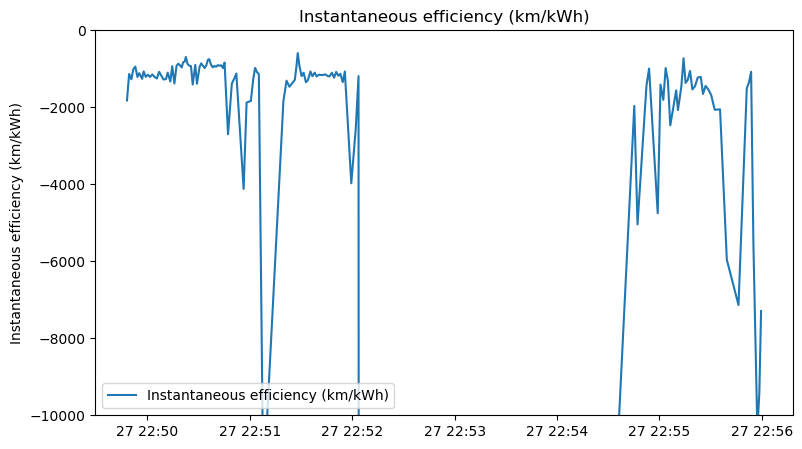

In [54]:
plot_instantaneous_efficiency(instantEfficiencyDataPoints)

/var/folders/1j/k4606sl10zbdbj7sx2vbhrcc0000gn/T/ipykernel_1780/1613655050.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


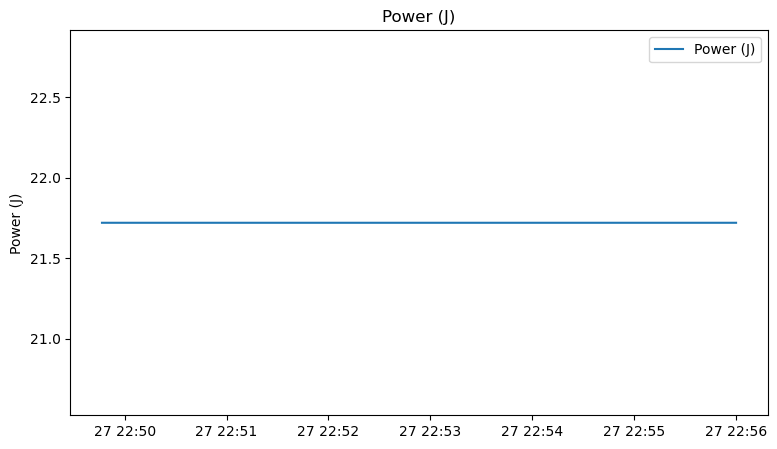

In [55]:
plot_power(processed)

/var/folders/1j/k4606sl10zbdbj7sx2vbhrcc0000gn/T/ipykernel_1780/1716530636.py:72: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


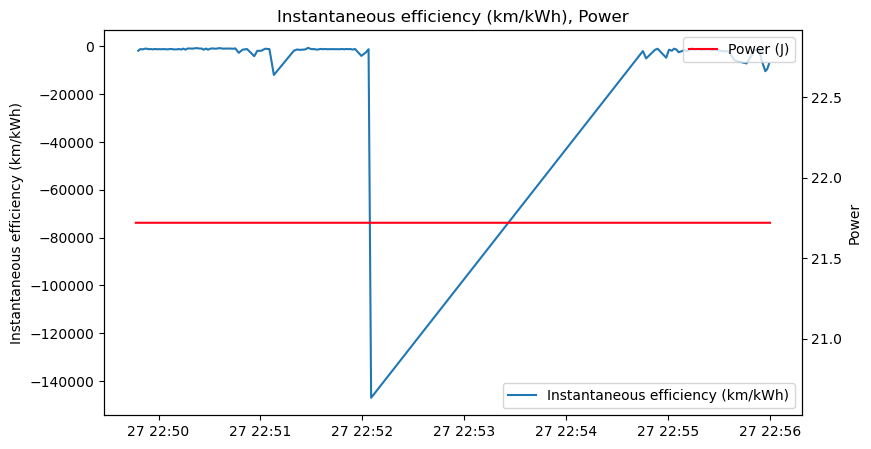

In [70]:
plot_power_and_efficiency(processed, instantEfficiencyDataPoints)

In [30]:
def timestamp_when_can_message(telemetry_data) -> pd.Timestamp:
    idx = telemetry_data['canMessage'].first_valid_index()  # Will return None
    time =  telemetry_data['time'].loc[idx] if idx is not None else None
    return time

timestamp_when_can_message(telemetry_data)

Timestamp('2023-09-22 20:04:54.121000+0000', tz='UTC')